## Here I investigate the impact of surface pressure and wind on sea level at the Dutch coast

In [1]:
#Load packages

import io
import requests
import netCDF4
import datetime
import functools
import zipfile
import SeaLevelContrib as slc

# computation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# statistics
import statsmodels.api as sm

import IPython.display


/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [5]:
#Define a few constants
rho_o = 1030 # Density of ocean water
g = 9.81 # Acceleration of gravity


0.010025434715913025

In [3]:
def find_closest(lat, lon, lat_i, lon_i):
    """lookup the index of the closest lat/lon"""
    Lon, Lat = np.meshgrid(lon, lat)
    idx = np.argmin(((Lat - lat_i)**2 + (Lon - lon_i)**2))
    Lat.ravel()[idx], Lon.ravel()[idx]
    [i, j] = np.unravel_index(idx, Lat.shape)
    return i, j

In [4]:
def make_pressure_df(lat_i=53, lon_i=3):
    """create a dataset for pressure, for 1 latitude/longitude"""
    p_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'+ \
            'ncep.reanalysis.derived/surface_gauss/pres.sfc.mon.mean.nc'

    # Open the file
    ds_p = netCDF4.Dataset(p_file)
    
    # read lat,lon, time from 1 dataset
    lat, lon, time = ds_p.variables['lat'][:], ds_p.variables['lon'][:], ds_p.variables['time'][:]
    
    # convert to datetime
    t = netCDF4.num2date(time, ds_p.variables['time'].units)
    
    # this is the index where we want our data
    i, j = find_closest(lat, lon, lat_i, lon_i)
    
    # get the pres variables
    print('found point', lat[i], lon[j])
    pres = ds_p.variables['pres'][:, i, j]
    
    # Inverse barometer effect in cm
    ibe = - pres/(rho_o*g)*100
    ibe = ibe - ibe.mean()
    
    # put everything in a dataframe
    pres_df = pd.DataFrame(data=dict( pres=pres, t=t, ibe=ibe))
    pres_df = pres_df.set_index('t')    
    
    annual_pres_df = pres_df.resample('A', label='left', loffset=datetime.timedelta(days=1)).mean()
    # Select data up to 2017 to be consistent with the tide gauge data
    annual_pres_df = annual_pres_df.loc[:'20170101'].copy()
    annual_pres_df.index = annual_pres_df.index.year
    
    # return it
    return annual_pres_df

annual_pres_df = make_pressure_df()
annual_pres_df[:10]


found point 52.3799 3.75


,pres,ibe
t,,
1948,100994.164062,-1.076909
1949,101126.664062,-2.388229
1950,100690.000000,1.933365
1951,100568.335938,3.137477
1952,100730.835938,1.529241
1953,101151.664062,-2.635640
1954,100679.164062,2.040573
1955,100848.335938,0.366374
1956,101004.164062,-1.175878


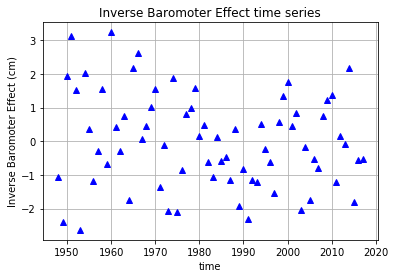

In [5]:
plt.plot(annual_pres_df.ibe, 'b^')
plt.xlabel('time')
plt.ylabel('Inverse Baromoter Effect (cm)')
plt.title('Inverse Baromoter Effect time series')
plt.grid(True)

In [6]:
# Read csv file of the sea level time series
ZSM_dir = '/Users/dewi/Work/Work_KNMI/SmallProjects/ZeespiegelMonitor/2018/Notebook/'
SeaLevel_df = pd.read_csv(ZSM_dir + 'SeaLevel_ZeespiegelMonitor')
SeaLevel_df = SeaLevel_df[SeaLevel_df['year'] >= 1948].copy()
SeaLevel_df = SeaLevel_df.set_index('year')
SeaLevel_df.height = SeaLevel_df.height*0.1 # convert from mm to cm
SeaLevel_IBECor = SeaLevel_df.height - annual_pres_df.ibe # sea level and IBE in centimeters
SeaLevel_df['ibe_corr'] = SeaLevel_IBECor
print(SeaLevel_df[:10])
print(type(SeaLevel_df))

SeaLevel_df = SeaLevel_df[SeaLevel_df.index >= 1993].copy()

print('Variance before IBE correction: ',np.var(SeaLevel_df.height))
print('Variance after IBE correction: ',np.var(SeaLevel_df.ibe_corr))
print(SeaLevel_df.corr())

        height     u2main     u2perp        u2        v2  ibe_corr
year                                                              
1948 -5.600000  11.503613  27.524968  2.858907  2.757849 -4.523091
1949 -4.216667  23.013540  17.134479  5.303430  0.321668 -1.828437
1950 -4.316667   0.252741   0.333975  3.816473  1.277195 -6.250032
1951 -5.850000   4.374529  12.047237  1.525014  1.779640 -8.987477
1952 -3.416667  23.929577   7.212613  3.440005 -0.038777 -4.945908
1953 -7.316667   8.799567   5.401693  2.938792  0.068979 -4.681026
1954 -4.550000   1.263615   1.533402  4.991529  1.373013 -6.590573
1955 -3.633333   2.454787   0.118953  1.712689 -0.228357 -3.999707
1956 -9.383333  11.521977   4.950728  1.996117  0.000106 -8.207455
1957 -6.083333  11.468944   9.229928  2.254755  0.185209 -5.789907
<class 'pandas.core.frame.DataFrame'>
Variance before IBE correction:  13.730531555555553
Variance after IBE correction:  13.987663826417117
            height    u2main    u2perp        u2       

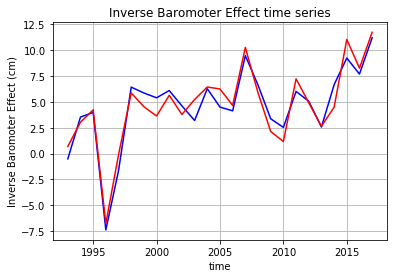

In [7]:
plt.plot(SeaLevel_df['height'], 'b-')
plt.plot(SeaLevel_df['ibe_corr'], 'r-')
plt.xlabel('time')
plt.ylabel('Inverse Baromoter Effect (cm)')
plt.title('Inverse Baromoter Effect time series')
plt.grid(True)

Test to apply IBE correction on individual tide gauges

In [8]:
# First read in the tide gauge data
tg_data_dir = '/Users/dewi/Work/Project_SeaLevelBudgets/rlr_annual'
names_col = ('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality')
filelist_df = pd.read_csv(tg_data_dir + '/filelist.txt', sep=';', header=None, names=names_col)
filelist_df = filelist_df.set_index('id')

id_NL = (20, 22, 23, 24, 25, 32)

names_col2 = ('year', 'height', 'interpolated', 'flags')
names_col3 = []

tg_data = {}
for i in range(len(id_NL)):
    interm     = pd.read_csv(tg_data_dir + '/data/' + str(id_NL[i]) + '.rlrdata', sep=';', 
                             header=None, names=names_col2)
    interm     = interm.set_index('year')
    tg_data[i] = (interm.height - interm.height.mean())*0.1 # Convert from mm to cm 
    names_col3.append(filelist_df['name'].loc[id_NL[i]].strip())

tg_data_df = pd.concat(tg_data, axis=1 )
tg_data_df.columns = names_col3
tg_data_df = tg_data_df[tg_data_df.index >= 1890].copy() 
    #1948 to fit with NCEP1 starting date, 1890 for zeespiegelmonitor
tg_data_df_mean = tg_data_df.mean(axis=1).copy() # This returns a series instead of a DataFrame
tg_data_df_mean = pd.DataFrame(tg_data_df_mean)
tg_data_df_mean.columns = ['height']

print(tg_data_df_mean.columns)
tg_data_df_mean['height']


Index(['height'], dtype='object')


year
1890   -12.154991
1891   -10.588324
1892    -9.338324
1893    -6.904991
1894    -6.871657
1895    -9.988324
1896   -11.188324
1897   -10.621657
1898    -6.521657
1899    -6.788324
1900   -10.338324
1901   -12.371657
1902   -15.204991
1903    -4.071657
1904    -7.871657
1905   -10.354991
1906    -6.671657
1907    -8.954991
1908    -9.671657
1909    -4.638324
1910    -3.721657
1911    -5.921657
1912     0.295009
1913    -2.571657
1914    -1.338324
1915    -5.121657
1916    -0.021657
1917    -5.471657
1918    -5.838324
1919    -8.054991
          ...    
1988    12.895009
1989     9.095009
1990    12.745009
1991     2.511676
1992     7.045009
1993     6.795009
1994    10.845009
1995    11.295009
1996    -0.088324
1997     5.645009
1998    13.745009
1999    13.178343
2000    12.711676
2001    13.411676
2002    11.928343
2003    10.511676
2004    13.595009
2005    11.811676
2006    11.445009
2007    16.795009
2008    13.945009
2009    10.678343
2010     9.845009
2011    13.328343
2012 

In [9]:
for i in range(len(id_NL)):
    print('Working on '+ names_col3[i])
    lat = filelist_df['lat'].loc[id_NL[i]]
    lon = filelist_df['lon'].loc[id_NL[i]]
    print(lat, lon)
    annual_pres_df = make_pressure_df(lat, lon)
    SeaLevel_IBECor = tg_data_df[names_col3[i]] - annual_pres_df.ibe
    tg_data_df_sel  = tg_data_df[ tg_data_df.index >= 1993 ].copy()
    print('Variance before IBE correction: ',np.var(tg_data_df_sel[names_col3[i]]))
    print('Variance after IBE correction: ',np.var(SeaLevel_IBECor[tg_data_df.index >= 1993]))

Working on VLISSINGEN
51.442222 3.596111
found point 52.3799 3.75
Variance before IBE correction:  10.904703999999999
Variance after IBE correction:  11.270149017809963
Working on HOEK VAN HOLLAND
51.9775 4.12
found point 52.3799 3.75
Variance before IBE correction:  9.779200000000001
Variance after IBE correction:  9.561445517859557
Working on DEN HELDER
52.964444 4.745
found point 52.3799 5.625
Variance before IBE correction:  11.173216000000002
Variance after IBE correction:  11.579176935771883
Working on DELFZIJL
53.326389 6.933056
found point 52.3799 7.5
Variance before IBE correction:  21.137536
Variance after IBE correction:  21.459274818562868
Working on HARLINGEN
53.175556 5.409444
found point 52.3799 5.625
Variance before IBE correction:  24.024543999999995
Variance after IBE correction:  24.309441629334753
Working on IJMUIDEN
52.462222 4.554722
found point 52.3799 3.75
Variance before IBE correction:  12.358144
Variance after IBE correction:  12.605429295617677


Check if ERA5 performs better than the NCEP1 reanalysis

In [10]:
def make_pressure_ERA5_df(lat_i=53, lon_i=3):
    """create a dataset for pressure, for 1 latitude/longitude"""
    p_file = '/Users/dewi/Work/Project_SeaLevelBudgets/ERA5/ERA5_msl.nc'

    # Open the file
    ds_p = netCDF4.Dataset(p_file)
    
    # read lat,lon, time from 1 dataset
    lat, lon, time = ds_p.variables['latitude'][:], ds_p.variables['longitude'][:], ds_p.variables['time'][:]
    
    # convert to datetime
    t = netCDF4.num2date(time, ds_p.variables['time'].units)
    
    # this is the index where we want our data
    i, j = find_closest(lat, lon, lat_i, lon_i)
    
    # get the pres variables
    print('found point', lat[i], lon[j])
    pres = ds_p.variables['msl'][:, i, j]
    
    # Inverse barometer effect in cm
    ibe = - pres/(rho_o*g)*100
    ibe = ibe - ibe.mean()
    
    # put everything in a dataframe
    pres_df = pd.DataFrame(data=dict( pres=pres, t=t, ibe=ibe))
    pres_df = pres_df.set_index('t')    
    
    annual_pres_df = pres_df.resample('A', label='left', loffset=datetime.timedelta(days=1)).mean()
    # Select data up to 2017 to be consistent with the tide gauge data
    annual_pres_df = annual_pres_df.loc[:'20170101'].copy()
    annual_pres_df.index = annual_pres_df.index.year
    
    # return it
    return annual_pres_df

annual_pres_df = make_pressure_ERA5_df()
annual_pres_df[-10:]


found point 53.0 3.0


,pres,ibe
t,,
2008,101364.597642,0.842397
2009,101340.993195,1.076005
2010,101352.177289,0.965318
2011,101555.963503,-1.051508
2012,101424.839241,0.246199
2013,101452.233340,-0.024914
2014,101191.221073,2.558266
2015,101593.652052,-1.424503
2016,101492.232652,-0.420778


In [11]:
tg_data_df = tg_data_df[tg_data_df.index >= 1979].copy()
#tg_data_df = tg_data_df[tg_data_df.index <= 2017].copy()
for i in range(len(id_NL)):
    print('Working on '+ names_col3[i])
    lat = filelist_df['lat'].loc[id_NL[i]]
    lon = filelist_df['lon'].loc[id_NL[i]]
    print(lat, lon)
    annual_pres_df = make_pressure_ERA5_df(lat, lon)
#    annual_pres_df = annual_pres_df[annual_pres_df.index >= 1993].copy()
#    annual_pres_df = annual_pres_df[annual_pres_df.index <= 2017].copy()
    SeaLevel_IBECor = tg_data_df[names_col3[i]] - annual_pres_df.ibe
    print('Variance before IBE correction: ',np.var(tg_data_df[names_col3[i]]))
    print('Variance after IBE correction: ',np.var(SeaLevel_IBECor))

Working on VLISSINGEN
51.442222 3.596111
found point 51.5 3.5
Variance before IBE correction:  14.49435897435898
Variance after IBE correction:  14.927374527587167
Working on HOEK VAN HOLLAND
51.9775 4.12
found point 52.0 4.0
Variance before IBE correction:  12.54060486522025
Variance after IBE correction:  12.615629941510285
Working on DEN HELDER
52.964444 4.745
found point 53.0 4.75
Variance before IBE correction:  11.92068376068376
Variance after IBE correction:  11.808783598756698
Working on DELFZIJL
53.326389 6.933056
found point 53.25 7.0
Variance before IBE correction:  24.067350427350434
Variance after IBE correction:  23.81725086345974
Working on HARLINGEN
53.175556 5.409444
found point 53.25 5.5
Variance before IBE correction:  23.089480604865223
Variance after IBE correction:  21.977309478681807
Working on IJMUIDEN
52.462222 4.554722
found point 52.5 4.5
Variance before IBE correction:  14.88095989480605
Variance after IBE correction:  15.001196660704919


Intermediate conclusion about the impact of inverse barometer effect. The IBE is not as high as I thought. Using NCEP1 reanalysis, applying the IBE reduces the variance of the time series at 1 out of 6 tide gauges. This number increases to 2 using ERA5 reanalysis. This is not very convincing on the necessity to use IBE to correct the signal. Except if IBE corrected signal correlates better with wind.

### Look into the wind effects on sea level from different model and wind products

In [12]:
def make_wind_df(lat_i=53, lon_i=3):
    """create a dataset for wind, for 1 latitude/longitude"""
    u_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/uwnd.10m.mon.mean.nc'
    v_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/vwnd.10m.mon.mean.nc'

    # open the 2 files
    ds_u = netCDF4.Dataset(u_file)
    ds_v = netCDF4.Dataset(v_file)
    
    # read lat,lon, time from 1 dataset
    lat, lon, time = ds_u.variables['lat'][:], ds_u.variables['lon'][:], ds_u.variables['time'][:]
    
    # check with the others
    lat_v, lon_v, time_v = ds_v.variables['lat'][:], ds_v.variables['lon'][:], ds_v.variables['time'][:]
    assert (lat == lat_v).all() and (lon == lon_v).all() and (time == time_v).all()
    
    # convert to datetime
    t = netCDF4.num2date(time, ds_u.variables['time'].units)
    
    # this is the index where we want our data
    i, j = find_closest(lat, lon, lat_i, lon_i)
    
    # get the u, v variables
    print('found point', lat[i], lon[j])
    u = ds_u.variables['uwnd'][:, i, j]
    v = ds_v.variables['vwnd'][:, i, j]
    
    # compute derived quantities
    speed = np.sqrt(u**2 + v**2)
    
    # compute direction in 0-2pi domain
    direction = np.mod(np.angle(u + v * 1j), 2*np.pi)
    
    # Compute the wind squared while retaining sign, as a approximation of stress
    u2 = u**2 * np.sign(u)
    v2 = v**2 * np.sign(v)
    
    # put everything in a dataframe
    wind_df = pd.DataFrame(data=dict(u=u, v=v, t=t, speed=speed, direction=direction, u2=u2, v2=v2))
    wind_df = wind_df.set_index('t')

    annual_wind_df = wind_df.resample('A', label='left', loffset=datetime.timedelta(days=1)).mean()
    annual_wind_df.index = annual_wind_df.index.year
    
    # return it
    return annual_wind_df
annual_wind_df = make_wind_df()
annual_wind_df[-10:]

found point 52.3799 3.75


,u,v,speed,direction,u2,v2
t,,,,,,
2010,0.842527,-0.395506,1.758827,2.393399,1.712336,-1.417380
2011,2.143113,1.469787,3.095699,1.707437,9.094103,4.225603
2012,2.191390,1.284763,2.981646,1.994099,6.817776,3.249124
2013,1.037140,0.346735,2.624925,3.413254,2.228657,3.173827
2014,1.564820,1.863233,3.526154,2.433411,5.123015,11.433274
2015,2.715002,1.360416,3.524224,2.121403,12.157925,6.558920
2016,1.751055,0.918265,2.507132,2.084224,4.917603,2.520684
2017,2.807551,1.063181,3.324518,1.234811,11.298989,2.050601
2018,1.040327,0.753799,2.777372,2.471112,4.296787,2.208767


Note that $u^2$ and $v^2$ are not the square of u and v for annual averages because they are computed from monthly averages. The assumption that monthly averaged wind are enough could be checked.

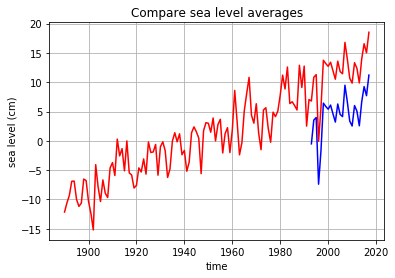

In [13]:
df_c = pd.concat([tg_data_df_mean, annual_wind_df], axis=1, join_axes=[tg_data_df_mean.index]) #annual_wind_df.index
df_c.index.names = ['year']
#df_c = df_c[np.isfinite(df_c['height'])] # This selects only the rows without nan values

#Plot time series
plt.plot(SeaLevel_df['height'], 'b-')
plt.plot(df_c['height'], 'r-')
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level averages')
plt.grid(True)


In [14]:
# define the statistical model, similar to zeespiegelmonitor
def linear_model(df, with_wind=True, with_ar=True):
    t = np.array(df.index)
    y = df['height']
    X = np.c_[
        t - 1970, 
        np.cos(2*np.pi*(t - 1970)/18.613),
        np.sin(2*np.pi*(t - 1970)/18.613)
    ]
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V']
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind $u^2$', 'Wind $v^2$'])
    X = sm.add_constant(X)
    if with_ar:
        model = sm.GLSAR(y, X, missing='drop', rho=1)
    else:
        model = sm.OLS(y, X, missing='drop')
    fit = model.fit(cov_type='HC0')
    return fit, names


In [15]:
linear_fit, names = linear_model(df_c, with_wind=False, with_ar=False)
table = linear_fit.summary(yname='Sea-surface height', xname=names, title='Linear model without wind (????-current)')
IPython.display.display(table)

linear_fit_w, names = linear_model(df_c, with_wind=True, with_ar=True)
table2 = linear_fit_w.summary(yname='Sea-surface height', xname=names, title='Linear model with wind (????-current)')
IPython.display.display(table2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Linear model without wind (????-current)                   
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     283.9
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           2.36e-55
Time:                        13:40:01   Log-Likelihood:                -316.92
No. Observations:                 128   AIC:                             641.8
Df Residuals:                     124   BIC:                             653.3
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       4.9119      0.291     16.869      0.000       4.341       5.483
Trend          0.1925      0.007     29.071      0.000       0.180       0.205
Nodal U        0.5168      0.370      1.396      0.163      -0.209       1.242
Nodal V       -1.2329      0.349     -3.528      0.000      -1.918      -0.548
==============================================================================
Omnibus:                        3.475   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                3.152
Skew:                          -0.383   Prob(JB):                        0.207
Kurtosis:                       3.072   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with wind (????-current)                     
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.874
Model:                          GLSAR   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     107.7
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           1.65e-29
Time:                        13:40:01   Log-Likelihood:                -140.65
No. Observations:                  69   AIC:                             293.3
Df Residuals:                      63   BIC:                             306.7
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       0.2740      0.550      0.498      0.618      -0.804       1.352
Trend          0.1791      0.013     13.432      0.000       0.153       0.205
Nodal U       -0.1936      0.332     -0.582      0.560      -0.845       0.458
Nodal V       -1.5240      0.297     -5.138      0.000      -2.105      -0.943
Wind $u^2$     0.7492      0.074     10.157      0.000       0.605       0.894
Wind $v^2$     0.0044      0.122      0.036      0.971      -0.235       0.243
==============================================================================
Omnibus:                        0.519   Durbin-Watson:                   1.301
Prob(Omnibus):                  0.771   Jarque-Bera (JB):                0.526
Skew:                           0.196   Prob(JB):                        0.769
Kurtosis:                       2.831   Cond. No.                         54.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [16]:
#This is a way to reproduce the results of .predict()
mod = np.array(linear_fit_w.params[:]) * np.array(linear_fit_w.model.exog[:,:]) 
mod_tot = mod.sum(axis=1)
wind_ef = mod[:,[4,5]].sum(axis=1)
other = mod[:,0:4].sum(axis=1)
print(names)
height_wind_cor = df_c.height[-len(wind_ef):] - wind_ef
# Test the trend with polyfit function
print("Wind fit, higher power first (unit is cm/y for linear trend): ")
np.polyfit(np.arange(len(wind_ef[-10:])), wind_ef[-10:], 1)



['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Wind $u^2$', 'Wind $v^2$']
Wind fit, higher power first (unit is cm/y for linear trend): 


array([ 0.2910504 ,  3.68852385])

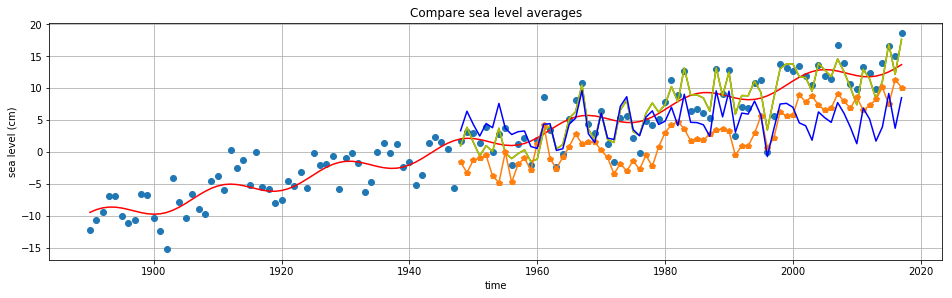

In [17]:
#Plot time series
fig, ax = plt.subplots(figsize=(16,16))
ax.plot(df_c.height, 'o')
ax.plot(linear_fit.model.exog[:, 1] + 1970,linear_fit.predict(), 'r-')
ax.plot(linear_fit_w.model.exog[:, 1] + 1970,linear_fit_w.predict(), 'g-')
ax.plot(linear_fit_w.model.exog[:, 1] + 1970, mod_tot, 'y-')
ax.plot(linear_fit_w.model.exog[:, 1] + 1970, height_wind_cor, 'p-')
ax.plot(linear_fit_w.model.exog[:, 1] + 1970, wind_ef, 'b-')
ax.set_aspect(1)
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level averages')
ax.grid(True)

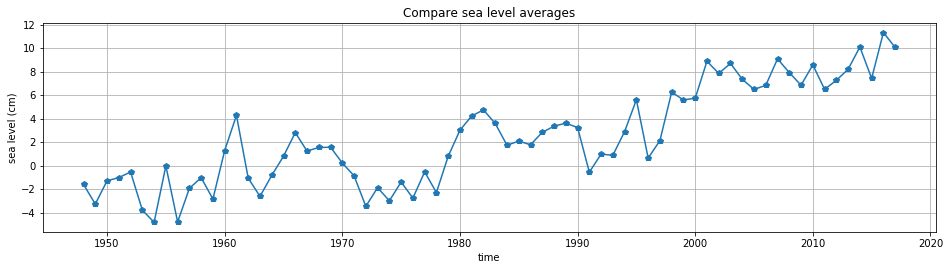

In [18]:
#Plot time series
fig, ax = plt.subplots(figsize=(16,16))
#ax.plot(linear_fit_w.model.exog[:, 1] + 1970, wind_ef, 'b-')
ax.plot(linear_fit_w.model.exog[:, 1] + 1970, height_wind_cor, 'p-')
ax.set_aspect(1)
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level averages')
ax.grid(True)

In [19]:
annual_pres_df = make_pressure_df()

height_wind_pres_cor = height_wind_cor - annual_pres_df.ibe

print('Variance before pressure correction:')
print(np.var(height_wind_cor))
print('Variance after pressure correction:')
print(np.var(height_wind_pres_cor))

found point 52.3799 3.75
Variance before pressure correction:
17.068521718771528
Variance after pressure correction:
18.589339536527834


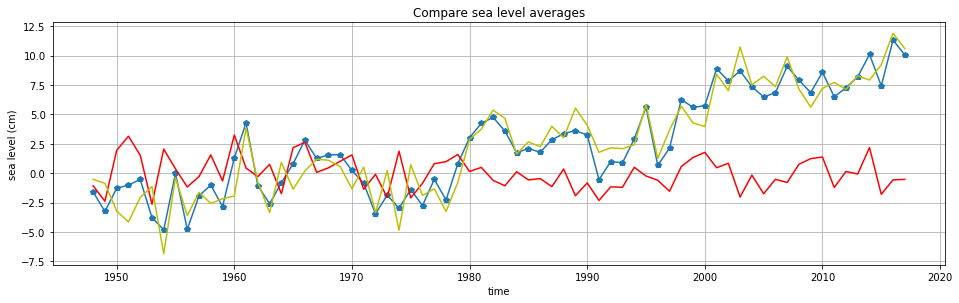

In [20]:
fig, ax = plt.subplots(figsize=(16,16))
ax.plot(linear_fit_w.model.exog[:, 1] + 1970, height_wind_cor, 'p-')
ax.plot(linear_fit_w.model.exog[:, 1] + 1970, annual_pres_df.ibe, 'r-')
ax.plot(linear_fit_w.model.exog[:, 1] + 1970, height_wind_pres_cor, 'y-')
ax.set_aspect(1)
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level averages')
ax.grid(True)

### Read WAQUA model outputs from Nina's run to compare with tide gauge observations:

In [21]:
# Available tide gauges: denhelde, ijmuiden, delfzijl, hoekvanh, harlinge, vlissing
dir_waqua = '/Users/dewi/Work/Project_SeaLevelBudgets/DataWAQUANinaERAI'
ds_wa = netCDF4.Dataset(dir_waqua+'/ERAintWAQUA_waterlevels_speed_1979_2015.nc')
dh = ds_wa['vlissing/WAQUA_surge'][:]*100
time_wa = ds_wa['time'][:]
t_wa = netCDF4.num2date(time_wa, ds_wa.variables['time'].units)

t_wa_y = np.empty_like(t_wa)
for i in range(len(t_wa)):
    t_wa_y[i] = t_wa[i].year
t_wa_y

array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015], dtype=object)

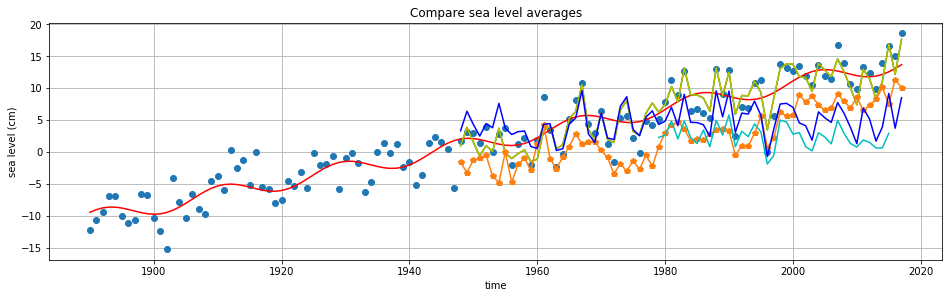

In [22]:
#Plot time series
fig, ax = plt.subplots(figsize=(16,16))
ax.plot(df_c.height, 'o')
ax.plot(linear_fit.model.exog[:, 1] + 1970,linear_fit.predict(), 'r-')
ax.plot(linear_fit_w.model.exog[:, 1] + 1970,linear_fit_w.predict(), 'g-')
ax.plot(linear_fit_w.model.exog[:, 1] + 1970, mod_tot, 'y-')
ax.plot(linear_fit_w.model.exog[:, 1] + 1970, height_wind_cor, 'p-')
ax.plot(linear_fit_w.model.exog[:, 1] + 1970, wind_ef, 'b-')
ax.plot(t_wa_y, dh, 'c-')
ax.set_aspect(1)
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level averages')
ax.grid(True)

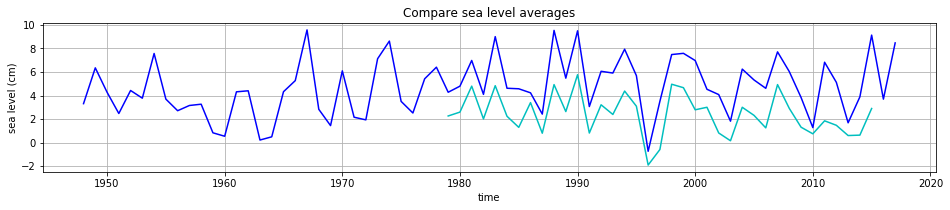

In [23]:
fig, ax = plt.subplots(figsize=(16,16))
#ax.plot(linear_fit_w.model.exog[:, 1] + 1970, wind_ef + annual_pres_df.ibe, 'b-')
ax.plot(linear_fit_w.model.exog[:, 1] + 1970, wind_ef, 'b-')
ax.plot(t_wa_y, dh, 'c-')
ax.set_aspect(1)
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level averages')
ax.grid(True)

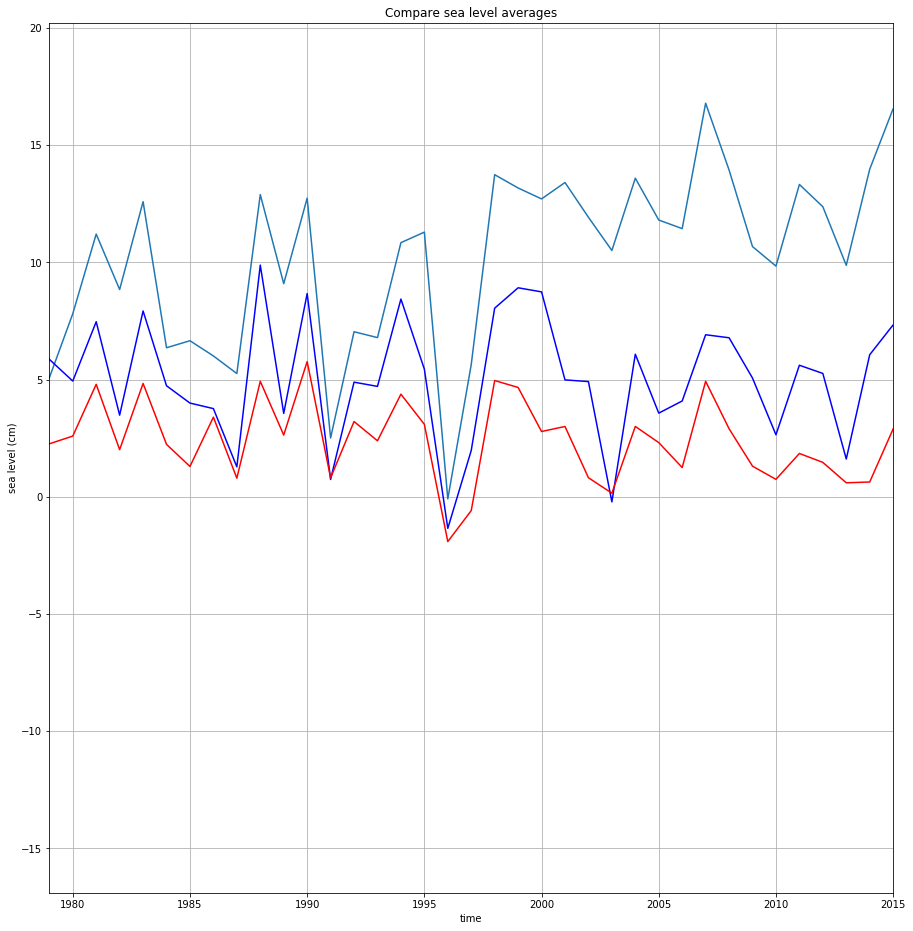

In [24]:
fig, ax = plt.subplots(figsize=(16,16))
ax.plot(df_c.height, '-')
ax.plot(linear_fit_w.model.exog[:, 1] + 1970, wind_ef + annual_pres_df.ibe, 'b-')
#ax.plot(linear_fit_w.model.exog[:, 1] + 1970, wind_ef, 'b-')
ax.plot(t_wa_y, dh, 'r-')
ax.set_aspect(1)
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level averages')
ax.set_xlim([1979,2015])
ax.grid(True)

Conclusion from this WAQUA analysis: There is a minor difference between the wind from the regression method and the winds from WAQUA. On the one hand this means that it is better to use a regression since WAQUA is a lot more complex. On the other WAQUA provides an estimate of wind impact on sea level that is independent from the tide gauges observations. This independence might is an advantage.

This conclusion of minor difference might not hold when compared with other contributors. Wind is one of the most important ones so even small differences might be relevant.

### Compare wind effects on sea level for individual tide gauges and from the mean

In [6]:
tg_id=[20, 22, 23, 24, 25, 32]

for i in range( len(tg_id)):
    tg_lat, tg_lon = slc.tg_lat_lon(tg_id[i])
    annual_wind_df = slc.make_wind_df(tg_lat, tg_lon)
    tgm_df = slc.tide_gauge_mean([tg_id[i]])
    df_c = pd.concat([tgm_df, annual_wind_df], axis=1, join_axes=[tgm_df.index])
    df_c.index.names = ['year']
    linear_fit, names = slc.linear_model_zsm(df_c, with_trend=True, with_nodal=True, 
                                             with_wind=True, with_ar=True)
    time_y = linear_fit.model.exog[:, 1] + 1970
    mod = np.array(linear_fit.params[:]) * np.array(linear_fit.model.exog[:,:])
    wind_ef = mod[:,[4,5]].sum(axis=1)
    if i==0:
        #col_name = str(tg_id[i])
        wind_ef_df = pd.DataFrame(data=dict(time=time_y, col_name=wind_ef))
        wind_ef_df = wind_ef_df.set_index('time')
        wind_ef_df.columns  = [str(tg_id[i])]
    else:
        wind_ef_df[str(tg_id[i])] = wind_ef

wind_ef_df.iloc[-10:]

found point 52.3799 3.75
found point 52.3799 3.75
found point 52.3799 5.625
found point 52.3799 7.5
found point 52.3799 5.625
found point 52.3799 3.75


,20,22,23,24,25,32
time,,,,,,
2008.0,2.918061,4.773283,5.581366,6.690724,7.462462,4.843296
2009.0,1.551235,2.534491,3.392288,3.882952,4.721850,2.978618
2010.0,1.028837,1.686974,1.474324,2.014008,1.610671,1.160567
2011.0,3.606162,5.901819,6.077656,6.482120,7.836713,5.583779
2012.0,2.690671,4.403416,4.883447,5.749458,6.342646,4.182107
2013.0,0.545735,0.890067,1.440202,2.123119,2.187663,1.262892
2014.0,0.600419,0.969606,2.852897,3.624640,4.832010,2.698857
2015.0,4.677281,7.653495,9.011124,10.453685,11.644996,7.420080
2016.0,1.912759,3.130069,3.684215,4.524808,4.748733,3.007778


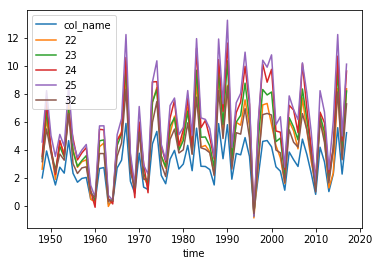

In [15]:
wind_ef_df.plot()

Some tide gauges are much more sensitive to wind than others.

In [8]:
# Compare average wind effect to the wind effect on average tide gauge time series
wind_ef_df['Average'] = wind_ef_df.mean(axis=1)

annual_wind_df = slc.make_wind_df(53, 3)
tgm_df = slc.tide_gauge_mean()
df_c = pd.concat([tgm_df, annual_wind_df], axis=1, join_axes=[tgm_df.index])
df_c.index.names = ['year']
linear_fit, names = slc.linear_model_zsm(df_c, with_trend=True, with_nodal=True, 
                                 with_wind=True, with_ar=True)
time_y = linear_fit.model.exog[:, 1] + 1970
mod = np.array(linear_fit.params[:]) * np.array(linear_fit.model.exog[:,:])
wind_mean_ef = mod[:,[4,5]].sum(axis=1)
wind_mean_ef_df = pd.DataFrame(data=dict(time=time_y, wind_mean_ef=wind_mean_ef))
wind_mean_ef_df = wind_mean_ef_df.set_index('time')

found point 52.3799 3.75


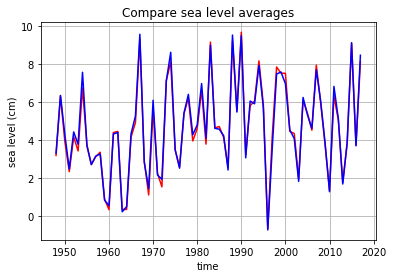

In [20]:
#Plot time series
fig, ax = plt.subplots()
ax.plot(wind_ef_df['Average'], 'r-')
ax.plot(wind_mean_ef_df, 'b-')

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level averages')
ax.grid(True)

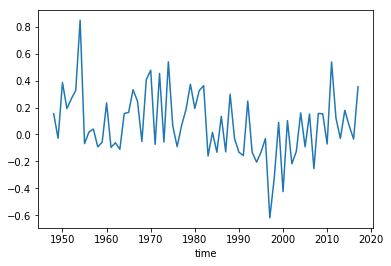

In [17]:
diff_df = wind_mean_ef_df['wind_mean_ef'] - wind_ef_df['Average']
diff_df.plot()

Conclusion: Despite large differences in wind effect at different tide gauges the difference between averaging the tide gauge sea level signals first and then computing the linear regression with wind compared to first computing the linear regression and then averaging the wind effect is not large.

### Effect of pressure

In [4]:
tg_id=[20, 22, 23, 24, 25, 32]
for i in range( len(tg_id)):
    tg_lat, tg_lon = slc.tg_lat_lon(tg_id[i])
    annual_wind_df = slc.make_wind_df(tg_lat, tg_lon)
    tgm_df = slc.tide_gauge_mean([tg_id[i]])
    df_c = pd.concat([tgm_df, annual_wind_df], axis=1, join_axes=[tgm_df.index])
    df_c.index.names = ['year']
    linear_fit, names = slc.linear_model_zsm(df_c, with_trend=True, with_nodal=True, 
                                             with_wind=True, with_pres=True, with_ar=True)
    time_y = linear_fit.model.exog[:, 1] + 1970
    mod = np.array(linear_fit.params[:]) * np.array(linear_fit.model.exog[:,:])
    wp_ef = mod[:,[4,5,6]].sum(axis=1)
    if i==0:
        #col_name = str(tg_id[i])
        wp_ef_df = pd.DataFrame(data=dict(time=time_y, col_name=wp_ef))
        wp_ef_df = wp_ef_df.set_index('time')
        wp_ef_df.columns  = [str(tg_id[i])]
    else:
        wp_ef_df[str(tg_id[i])] = wp_ef

wp_ef_df.iloc[-10:]

found point 52.3799 3.75
found point 52.3799 3.75
found point 52.3799 5.625
found point 52.3799 7.5
found point 52.3799 5.625
found point 52.3799 3.75


,20,22,23,24,25,32
time,,,,,,
2008.0,-817.690140,-664.821180,-662.743748,-305.186505,-640.959238,-645.063910
2009.0,-818.663565,-666.738967,-664.572272,-307.792031,-643.350033,-646.617021
2010.0,-819.070601,-667.492352,-666.224006,-309.471686,-646.202911,-648.343707
2011.0,-818.623341,-665.015583,-663.573042,-306.017401,-641.871094,-645.607469
2012.0,-818.419552,-665.600684,-663.846523,-306.298901,-642.471853,-646.122692
2013.0,-820.740838,-669.257930,-667.350814,-309.933018,-646.686063,-649.181573
2014.0,-818.839534,-667.671598,-664.664064,-307.919954,-642.805605,-646.283117
2015.0,-818.031667,-663.655122,-660.970281,-302.158942,-638.383669,-644.150880
2016.0,-819.784132,-667.352736,-665.478846,-307.714079,-644.485959,-647.761650


Adding the pressure as a regressor changes the mean of the time series a lot. Why is that???

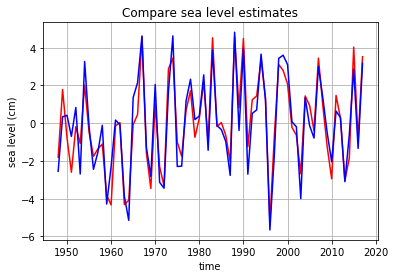

In [12]:
wp_ef_df['Average'] = wp_ef_df.mean(axis=1)

#Plot time series
fig, ax = plt.subplots()
ax.plot(wind_ef_df['Average'] - wind_ef_df['Average'].mean(), 'r-')
ax.plot(wp_ef_df['Average'] - wp_ef_df['Average'].mean(), 'b-')

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level estimates')
ax.grid(True)


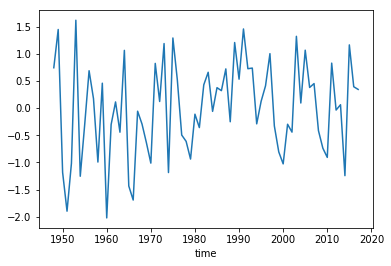

In [22]:
diff2_df = wind_ef_df['Average'] - wp_ef_df['Average']
diff2_df = diff2_df - diff2_df.mean(axis=0)
diff2_df.plot()

Adding pressure to the regression variables has a large effect on the result. 
Including on the 10-20 years trends. These can be up to 1mm/year. But does it decrease the budget error?